# Rearrange cutout size for specific sample

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
from photutils.segmentation import SegmentationImage

In [11]:
img_name = 'nircam6'
prep_base = './io/prep/' + img_name + '/'
sample_base = './io/sample/' + img_name + '/'

In [12]:
pregalfit_path = prep_base + 'pregalfit.fits'
with fits.open(pregalfit_path) as hdul:
    tab_img = Table(hdul[1].data)
    tab_ini = Table(hdul[2].data)
    segm = SegmentationImage(hdul[3].data)
img_path_list = list(tab_img['img_path'])

## Proceed which sample?

In [228]:
idx_pcd = np.where(tab_ini['kron_radius']>15)[0]
tab_pcd = tab_ini[idx_pcd]
tab_pcd

ID,RA,Dec,comment,KronPhot_F115W_mag,KronPhot_F150W_mag,KronPhot_F200W_mag,KronPhot_F277W_mag,KronPhot_F356W_mag,KronPhot_F410M_mag,KronPhot_F444W_mag,label,xcentroid,ycentroid,semimajor_sigma,semiminor_sigma,orientation,eccentricity,kron_radius
int64,float64,float64,str22,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
11067,214.86403889,52.81538111,0,25.02495068277892,24.81560071498985,24.507564927753915,23.226638007416977,22.644928006138358,21.719275457920823,21.486311692999543,30371,6403.010507311094,593.8649476579196,9.233361113685952,6.2009170041841735,8.814846508636217,0.740934372455153,24.597366426973384
11587,214.91397111,52.85361306,not deblended properly,19.914102591226953,19.495278034048226,19.331576912756354,19.006553549165574,19.16282696456563,19.380517960111227,19.40976974362155,29628,680.838434435028,702.600450029853,70.95601866306689,20.44879110311708,-22.257597770586614,0.9575733487133259,53.32814467215099
12699,214.90691306,52.85449694,0,17.939204563558746,17.735217561586712,17.96648046769206,18.844528579087697,18.7135612576827,18.393005227219138,18.954373039734,30810,834.202275173121,1190.5012715949256,54.802757447188235,8.42349398244239,-80.80520756627965,0.9881166784345999,73.07667042938458
16728,214.87853306,52.85558694,0,26.15220414945961,25.49979835639102,25.715814224454963,25.00697090154946,25.124817269835336,25.01956742924032,24.972920746588212,35965,2045.6833108842086,2917.964819308735,8.440767183123459,4.932107909374627,-88.6421500879775,0.8115234437381,15.3084985206118
18384,214.864405,52.85368806,0,25.21120058941791,24.751436785562717,24.668629412952477,24.354403604814777,24.178773328944395,24.280256126637568,24.075827766112784,37512,2881.708982571045,3547.2617028872805,7.947483899531026,4.8956521800832284,43.34340445860149,0.7877459455797258,15.729650016548142
35490,214.91408,52.856145,not deblended properly,15.694317341535271,15.741629420196448,16.281774477597136,16.991586049946868,17.254513885455633,16.84543792729429,17.445052426340155,29625,342.78860442245684,388.69600358443404,90.38156035372441,13.359335700317406,88.95207146592819,0.9890157137352896,94.34556939983787
35543,214.91381194,52.85686111,not deblended properly,21.381749240240243,20.94249680147601,20.872105080210225,20.428356097696938,20.273621219060182,20.081320822891392,20.075396180042986,29629,317.4578299648483,1152.3138006569,27.410557767654655,16.427752457351822,37.13361569114122,0.8005079925164081,29.708180037507287
37084,214.83360389,52.82656889,0,21.019180684517,20.825810436987723,21.17692062132914,20.685278405486237,21.107511195966254,21.438724960421553,21.498617576234345,35982,6812.454024239745,3145.5112832573977,12.73835721132955,8.396547013568657,61.25396641161669,0.7520074376353459,41.027696112202484
37865,214.88146389,52.87382111,not deblended properly,22.46893536973616,21.923063915319123,21.62865139234157,20.993536946145568,20.816318665053032,20.632098260463145,20.5899931313323,38734,238.07492734159766,4169.82364825345,9.24719855434858,7.736926424158762,-55.59907763203515,0.5476952945355484,43.738427696793536


## Rearange Cutout

In [4]:
from utils.segmentcut import cutout, SegmCut

In [15]:
id = 12608
row = tab_ini[ id==tab_ini['ID'] ]
size = 60
sample_dir = sample_base + str(id) + '/'
x_c = row['xcentroid'][0]
y_c = row['ycentroid'][0]
areas = segm.areas
segm_cut = cutout(segm.data, x_c, y_c, size)
sc = SegmCut(segm_cut, (x_c, y_c), size, areas, [row['label'][0]] ,verbose=False)

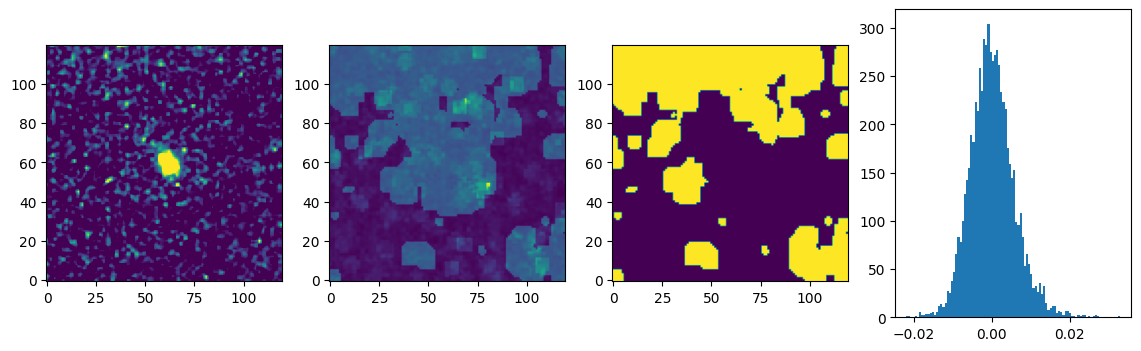

In [16]:
for img_path in img_path_list[::-1]:
    with fits.open(img_path) as hdul:
        sci_cut = cutout(hdul['SCI_BKSUB'].data, x_c, y_c, size)
        err_cut = cutout(hdul['ERR'].data, x_c, y_c, size)
    scimap, errmap, bpmask, data1d = sc.gen_cutout(sci_cut, err_cut, hist=True)
    fig, ax = plt.subplots(1, 4, figsize=(14,4))

    ax[0].imshow(scimap, origin='lower', vmin=np.percentile(scimap[~bpmask], 60), vmax=np.percentile(scimap[~bpmask], 99))
    ax[1].imshow(errmap, origin='lower')
    ax[2].imshow(bpmask, origin='lower')
    ax[3].hist(data1d, bins=100)
    break

In [17]:
band_list = ['F115W', 'F150W', 'F200W', 'F277W', 'F356W', 'F410M', 'F444W']
for img_path,band in zip(img_path_list,band_list):
    with fits.open(img_path) as hdul:
        sci_cut = cutout(hdul['SCI_BKSUB'].data, x_c, y_c, size)
        err_cut = cutout(hdul['ERR'].data, x_c, y_c, size)
    scimap, errmap, bpmask = sc.gen_cutout(sci_cut, err_cut)

    sci_path = sample_dir + 'sci_' + band + '.fits'
    hdr_sci = fits.Header()
    hdr_sci['EXTNAME'] = 'SCI_BKSUB'
    hdr_sci['xc'] = x_c
    hdr_sci['yc'] = y_c
    fits.writeto(sci_path, scimap, header=hdr_sci, overwrite=True)

    err_path = sample_dir + 'err_' + band + '.fits'
    hdr_err = fits.Header()
    hdr_err['EXTNAME'] = 'ERR'
    hdr_err['xc'] = x_c
    hdr_err['yc'] = y_c
    fits.writeto(err_path, errmap, header=hdr_err, overwrite=True)
                
    bpmask_path = sample_dir + 'bpmask_' + band + '.fits'
    hdr_bpmask = fits.Header()
    hdr_bpmask['EXTNAME'] = 'BPMASK'
    hdr_bpmask['xc'] = x_c
    hdr_bpmask['yc'] = y_c
    fits.writeto(bpmask_path, bpmask.astype(int), header=hdr_bpmask, overwrite=True)